# <span style="color:firebrick"> Esercitazione 10</span>

### <span style="color:firebrick"> Exercise 10.1

<span style="color:red">Choose **ONLY ONE** of the two following possibilities:

<span style="color:red">1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

<span style="color:red">2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lowest temperature. 

### <span style="color:firebrick"> Exercise 10.2

<span style="color:red">Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

<span style="color:red">If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

<span style="color:red">If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?


## Parallel computing

Il parallel computing consiste nel dividere l'esecuzione di un codice su più processori che lavorano parallelamente. Se il numero di CPU è $p$, il tempo $t_p$ necessario per raggiungere l'obiettivo può essere diminuito a $t_p=t_1/p$  (dove $t_1$ è il tempo per completare l'obiettivo in serie).

In un computer con $p$ processori, chiamiamo $T_p$ il tempo speso per svolgere un task usando un algoritmo parallelo. Si danno le seguenti definizioni:
- Cost: $C_p=p\times T_p$
- Speed-up: $S_p=T_1/T_p$
- Efficency: $E_p=S_p/p=T_1/C_p$
Si cerca di ottenere il massimo speed-up con la maggiore efficienza possibile $E_p\times S_p$.

Seguiremo il modello SPMD _Single Program Multiple Data_ in cui si parallelizza usando lo stesso algoritmo per trattare parti diverse del dataset. Ogni processo è contraddistinto da un numero intero, il _rank_. Tutti i processi leggono l'array e prendono il proprio rank. Ogni processo legge di quale parte di array si deve occupare e lo processa. Alla fine si raccolgono tutti i dati in un processo, che si occupa di scrivere il file di output. Per mettere in comunicazione i diversi processi si usa la libreria MPI 

MPI (Message Passing Interface) è una libreria standard per la programmazione parallela distribuita: il programma viene eseguito da più processi distinti, ognuno con la sua memoria e i processi possono comunicare scambiandosi messaggi (dati) tramite funzioni MPI. Tutti i processi partono dallo stesso codice ma sanno quale rank hanno, così possono eseguire parti diverse del codice a seconda del proprio ruolo.


Nel codice analizziamo una situazione in cui abbiamo una popolazione complessiva di 500 individui, suddivisi in 5 continenti da 100 individui ciascuno. La popolazione evolve per 2000 generazione. Analizziamo sia il caso in cui l'algoritmo genetico viene eseguito in parallelo da 5 processi senza che ci sia comunicazione intermedia. In un secondo momento mettiamo in comunicazione i continenti, facendo scambiare tra loro alcuni tra i migliori individui. La parallelizzazione migliora il tempo di esecuzione del programma. Con l'introduzione delle migrazioni ci si aspettano delle prestazioni migliori (a parità di risorse iniziali) perchè si contrasta la possibilità che la ricerca di minimo si stabilizzi in un minimo locale: la scelta di avere una popolazione elitaria, unita al fatto che il crossover avviene selezionando con maggiore probabilità gli individui migliori, introducono un bias nel sistema che tende a far somigliare i figli agli individui migliori. Avere più continenti che lavorano separatamente alla ricerca di minimo permette di avere un rimescolamento.

###### 

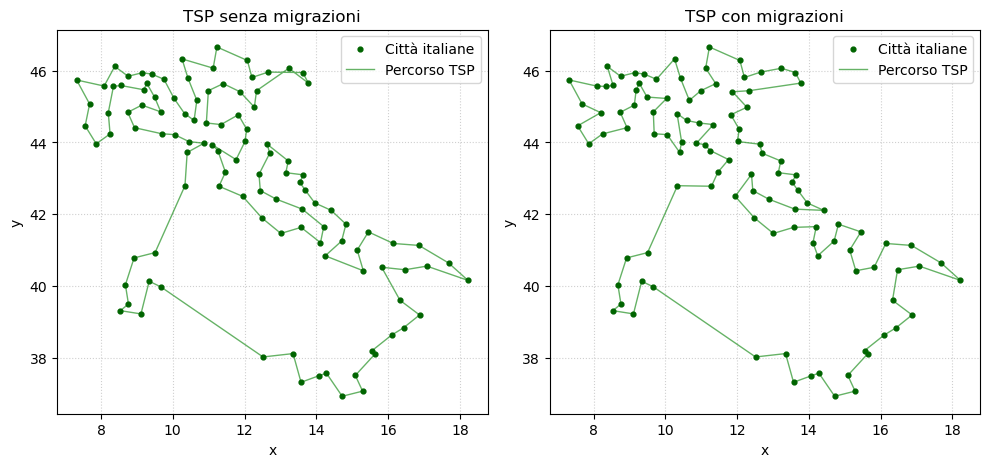

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# --- Italia: coordinate città ---
data = np.loadtxt("cap_prov_ita.dat")
x = data[:, 0]
y = data[:, 1]

# --- Caricamento percorsi ---
best_nomig = np.loadtxt("best_path_nomig.dat", dtype=int)
best_mig   = np.loadtxt("best_path_mig.dat", dtype=int)

city_nomig = best_nomig[:, 1]
city_mig   = best_mig[:, 1]

# --- Ricostruzione percorsi ---
x_nomig = np.append(x[city_nomig], x[city_nomig][0])
y_nomig = np.append(y[city_nomig], y[city_nomig][0])

x_mig = np.append(x[city_mig], x[city_mig][0])
y_mig = np.append(y[city_mig], y[city_mig][0])

# --- Figura con due pannelli affiancati ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# ---------- SENZA MIGRAZIONI ----------
ax = axes[0]
ax.scatter(x, y, s=12, color='darkgreen', zorder=3, label="Città italiane")
ax.plot(x_nomig, y_nomig, color='green', alpha=0.6, lw=1, label="Percorso TSP")
ax.set_title("TSP senza migrazioni")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, linestyle=':', alpha=0.6)
ax.set_aspect('equal', adjustable='box')
ax.legend()

# ---------- CON MIGRAZIONI ----------
ax = axes[1]
ax.scatter(x, y, s=12, color='darkgreen', zorder=3, label="Città italiane")
ax.plot(x_mig, y_mig, color='green', alpha=0.6, lw=1, label="Percorso TSP")
ax.set_title("TSP con migrazioni")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, linestyle=':', alpha=0.6)
ax.set_aspect('equal', adjustable='box')
ax.legend()

plt.tight_layout()
plt.show()


Rank 1 - Best fitness finale: 58.234700
Rank 2 - Best fitness finale: 59.125000
Rank 3 - Best fitness finale: 58.477300
Rank 4 - Best fitness finale: 61.046000
Rank 5 - Best fitness finale: 64.190600
Rank 6 - Best fitness finale: 58.215600


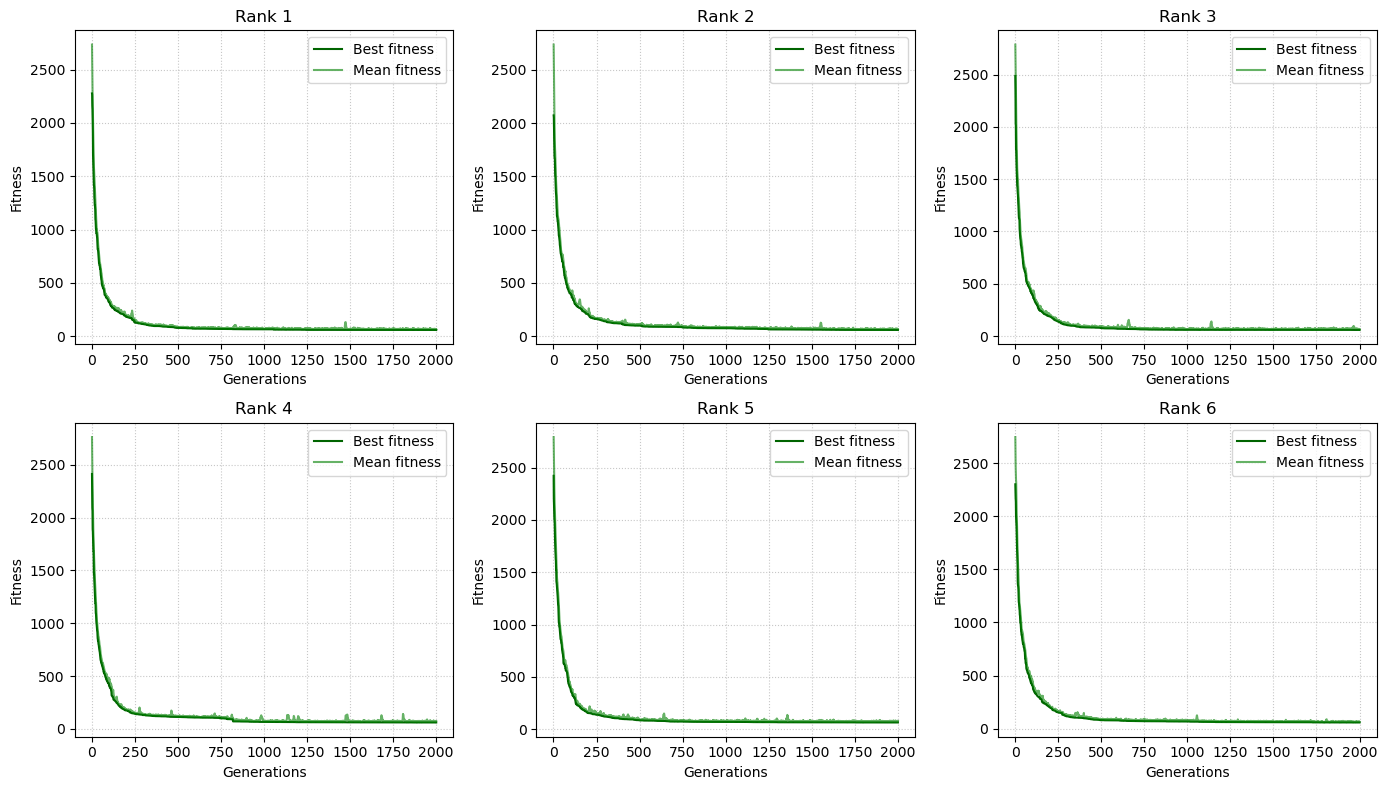

In [54]:
import matplotlib.pyplot as plt

filename = "mean_fitness_nomig.dat"

# Dizionario per salvare i dati per ogni rank
rank_data = {}

# Lettura file
with open(filename, "r") as f:
    for line in f:
        parts = line.split()
        if len(parts) != 4:
            continue

        rank = int(parts[0])
        gen  = int(parts[1])
        best = float(parts[2])
        mean = float(parts[3])

        if rank not in rank_data:
            rank_data[rank] = {"gen": [], "best": [], "mean": []}

        rank_data[rank]["gen"].append(gen)
        rank_data[rank]["best"].append(best)
        rank_data[rank]["mean"].append(mean)

# Numero di rank
ranks = sorted(rank_data.keys())
n_ranks = len(ranks)

# Preparazione figura 2 righe × 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, rank in enumerate(ranks):
    data = rank_data[rank]

    ax = axes[i]
    ax.plot(data["gen"], data["best"], label="Best fitness", color='darkgreen')
    ax.plot(data["gen"], data["mean"], label="Mean fitness", color='green', alpha=0.6)

    ax.set_title(f"Rank {rank+1}")
    ax.set_xlabel("Generations")
    ax.set_ylabel("Fitness")
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend()

    # Stampa ultima best fitness
    final_best = data["best"][-1]
    print(f"Rank {rank+1} - Best fitness finale: {final_best:.6f}")

# Nasconde eventuali subplot vuoti (se meno di 6 ranks)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Rank 1 - Best fitness finale: 54.486200
Rank 2 - Best fitness finale: 54.486200
Rank 3 - Best fitness finale: 54.486200
Rank 4 - Best fitness finale: 54.486200
Rank 5 - Best fitness finale: 54.486200
Rank 6 - Best fitness finale: 54.669400


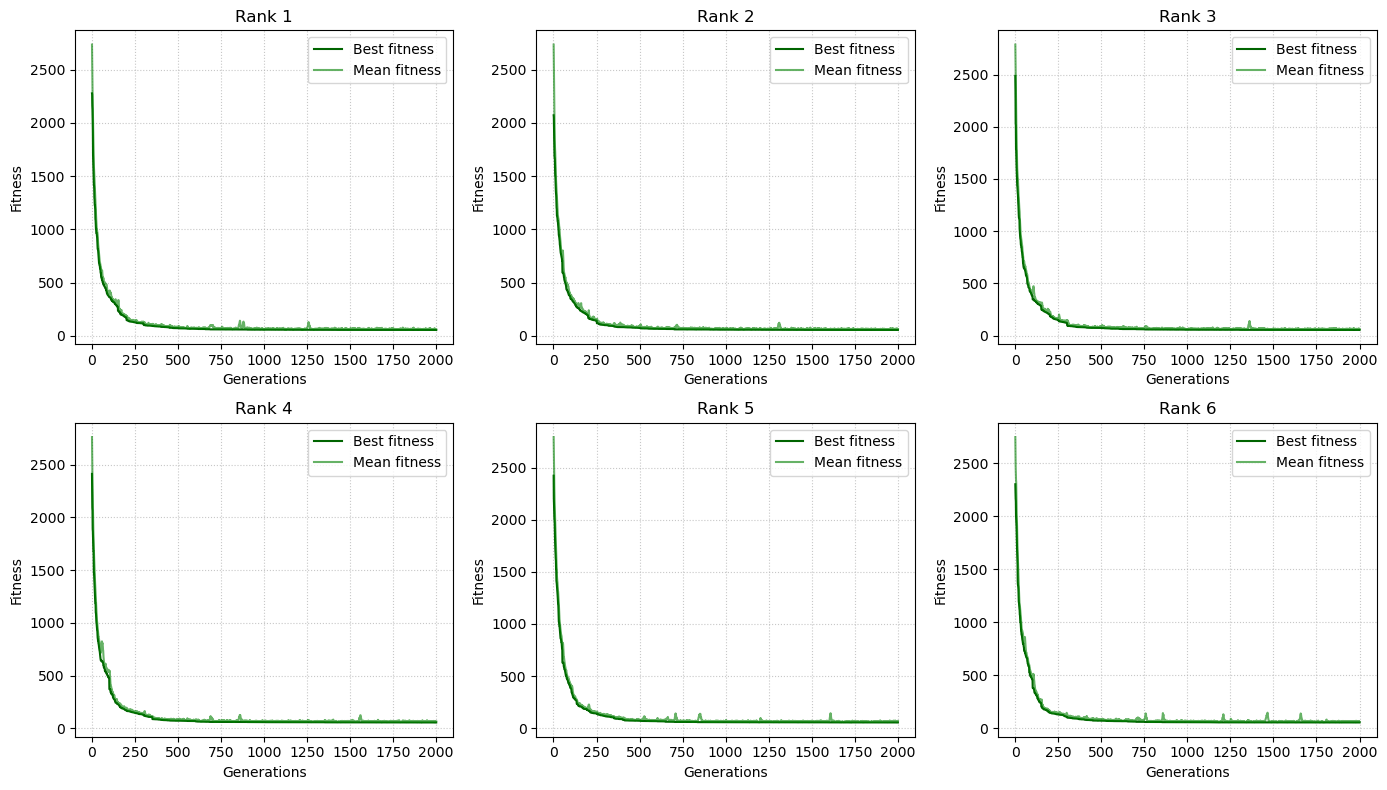

In [49]:
import matplotlib.pyplot as plt

filename = "mean_fitness_mig.dat"

# Dizionario per salvare i dati per ogni rank
rank_data = {}

# Lettura file
with open(filename, "r") as f:
    for line in f:
        parts = line.split()
        if len(parts) != 4:
            continue

        rank = int(parts[0])
        gen  = int(parts[1])
        best = float(parts[2])
        mean = float(parts[3])

        if rank not in rank_data:
            rank_data[rank] = {"gen": [], "best": [], "mean": []}

        rank_data[rank]["gen"].append(gen)
        rank_data[rank]["best"].append(best)
        rank_data[rank]["mean"].append(mean)

# Numero di rank
ranks = sorted(rank_data.keys())
n_ranks = len(ranks)

# Preparazione figura 2 righe × 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, rank in enumerate(ranks):
    data = rank_data[rank]

    ax = axes[i]
    ax.plot(data["gen"], data["best"], label="Best fitness", color='darkgreen')
    ax.plot(data["gen"], data["mean"], label="Mean fitness", color='green', alpha=0.6)

    ax.set_title(f"Rank {rank+1}")
    ax.set_xlabel("Generations")
    ax.set_ylabel("Fitness")
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend()

    # Stampa ultima best fitness
    final_best = data["best"][-1]
    print(f"Rank {rank+1} - Best fitness finale: {final_best:.6f}")

# Nasconde eventuali subplot vuoti (se meno di 6 ranks)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Osservazioni fatte cambiando i parametri:

- Aumentando il numero di individui nella popolazione e aumentando il numero di generazioni si osservano risultati migliori. Tuttavia, come si vede dai grafici riportati sopra, dopo un certo numero di generazioni il valore della best fitness tende a stabilizzarsi, e così anche la best fitness media. Nei grafici si osserva che la best fitness media calcolata per la metà migliore degli individui si avvicina molto alla best fitness. Questo comportamento suggerisce che la popolazione è costituita prevalentemente da buoni individui, il problema è che questi potrebbero essere troppo simili tra loro, rendendo "inutile" l'operazione di crossover e molto più lenta la ricerca. Andando avanti con il numero di generazioni diventa importante mantenere una certa diversità tra gli individui. 
- se si sceglie un parametro `_p`troppo alto (superiore a 3) si osserva che ci si blocca in un minimo locale perchè vengono favoriti sempre gli individui migliori e la popolazione tende ad essere costituita da individui molto simili tra loro. In questo modo l'unica speranza che si esca dal minimo è avere mutazioni "non distruttive" che modificano di poco il percorso, ma rimane comunque molto complicato risolvere il problema -> meglio scegliere un peso più basso.
- facendo uso dell'elitarietà questo problema aumenta perchè si genera un bias che viene propagato a tutti i continenti tramite la migrazione.

Nei risultati riportati è stato scelto un peso $p=2.3$ e a ogni generazione si salva il migliore individuo per ogni continente. Ogni $50$ generazioni l'individuo migliore viene spedito a un altro continente ( $1\rightarrow 2$, $2\rightarrow 3$, ...). Si sceglie di tenere le mutazioni alte per contrastare il fenomeno descritto in precedenza, con un `M_RATE` del $44\%$ (vengono tenute attive tutte e quattro le tipologia di mutazioni implementate nell'esercitazione 9).